In [29]:
import os
import sys

from pathlib import Path

# Get the current working directory
cwd = Path(os.getcwd())

# Assuming your notebook is in the project root, set the project root as cwd
project_root = cwd.parent
print(project_root)

# If your notebook is in a subdirectory of the project root, you can modify the path accordingly:
# project_root = cwd.parent  # Go up one directory level
# project_root = cwd.parent.parent  # Go up two directory levels

# Add the project root directory to sys.path
sys.path.insert(0, str(project_root))
# sys.path.append('../')

import xpt.fit_analysis as xfa
import warnings
import corr_fitter.bs_utils as bs
import corr_fitter.bs_analysis as bs_analysis
import corr_fitter.load_data_priors as ld
import corr_fitter.corr_fit_analysis as fa
import xpt.priors as priors
import xpt.i_o as i_o
import xpt.fit_routine as fit
import xpt.plots as plots
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib
import tqdm
import h5py as h5
import yaml
import io
import lsqfit
import os
import importlib
import numpy as np
import gvar as gv
import pandas as pd
# from h5glance import H5Glance


warnings.simplefilter(action="default")
warnings.filterwarnings('ignore')


/home/gmoney/lqcd/hyperon-xpt-master


In [30]:
# Define paths and other variables
base_dir = "/home/gmoney/lqcd/hyperon-xpt-master"
input_dir = os.path.join(base_dir, "tests/input_files")
data_dir = os.path.join(base_dir, "data")
fit_results_dir = os.path.join(base_dir, "fit_results")
data_file = os.path.join(data_dir, "c51_2pt_octet_decuplet.h5")
hyperon_data_file = os.path.join(data_dir,"hyperon_data.h5")
bs_data_file = os.path.join(data_dir, "hyperon_bs_data.h5")
model_type = "all"
t_plot_min = 0
t_plot_max = 40
bs_N = 100
bs_seed = "seed"

In [39]:
importlib.reload(i_o)
input_output = i_o.InputOutput()
data = input_output.get_data()
print(data)
scale_setting_data = input_output.get_scale_setting_data()
# print(scale_setting_data)
# hyperon_data = ld.get_hyperon_posterior(bs_data=scale_setting_data)

# data,ensembles = input_output.get_data(scheme='w0_imp',units='Fpi')
# data_div, ensembles = input_output.get_data(scheme='w0_imp',units='Fpi')
# prior = input_output.make_prior(data,priors)
# phys_point_data = input_output.get_data_phys_point()


['a06m310L', 'a09m135', 'a09m350', 'a09m400', 'a12m130', 'a12m220L', 'a12m220S', 'a12m310', 'a12m350', 'a12m400', 'a15m220', 'a15m310']
({'m_lambda': array([1255(11), 1260(10), 1303(10), 1090.9(8.0), 1123.2(8.2),
       1134.4(8.3), 1187.4(8.7), 1213.4(8.8), 1252.5(9.1), 1103.0(7.3),
       1162.1(7.7)], dtype=object), 'm_sigma': array([1311(12), 1312(11), 1346(11), 1186.1(8.7), 1208.5(8.8),
       1211.0(8.8), 1248.0(9.1), 1275.2(9.3), 1297.8(9.5), 1194.4(7.9),
       1236.8(8.2)], dtype=object), 'm_sigma_st': array([1501(13), 1571(13), 1600(13), 1461(11), 1480(11), 1481(11),
       1506(11), 1535(11), 1556(11), 1442.6(9.6), 1499(10)], dtype=object), 'm_xi_st': array([1642(15), 1625(13), 1671(13), 1535(11), 1555(11), 1558(11),
       1580(12), 1598(12), 1622(12), 1517(10), 1557(10)], dtype=object), 'm_xi': array([1410(13), 1388(11), 1411(11), 1271.4(9.3), 1282.4(9.4),
       1288.3(9.4), 1318.5(9.6), 1335.6(9.7), 1357.8(9.9), 1257.6(8.4),
       1294.3(8.6)], dtype=object), 'm_omega':

In [ ]:
import pprint
import os.path
fit_results = {}

fit_results = {}
directory = 'fit_results/'

with h5.File('/home/gmoney/lqcd/data/c51_2pt_octet_decuplet.h5', "r") as f:
    ens = sorted(list(f.keys()))
    print(ens)
    for key in ens:
        file_path = directory + key + '/all/fit_params'
        if os.path.isfile(file_path):
            fit_results[key] = gv.load(file_path)
        else:
            print(f"File not found for key {key}")
pprint.pprint(fit_results)


['a06m220L', 'a06m310', 'a06m310L', 'a09m135', 'a09m220', 'a09m220_new_old', 'a09m220_o', 'a09m260', 'a09m310', 'a09m310_new_old', 'a09m310_o', 'a09m350', 'a09m400', 'a12m130', 'a12m180L', 'a12m180S', 'a12m220', 'a12m220L', 'a12m220S', 'a12m220XL', 'a12m220_ms', 'a12m220_new_old', 'a12m220_o', 'a12m260', 'a12m310', 'a12m310L', 'a12m310XL', 'a12m350', 'a12m400', 'a15m130', 'a15m135XL', 'a15m220', 'a15m260', 'a15m310', 'a15m310L', 'a15m310L_new_old', 'a15m310L_o', 'a15m350', 'a15m400']
File not found for key a06m310
File not found for key a09m220
File not found for key a09m220_new_old
File not found for key a09m310
File not found for key a09m310_new_old
File not found for key a12m180S
File not found for key a12m220
File not found for key a12m220XL
File not found for key a12m220_new_old
File not found for key a12m310XL
File not found for key a15m310L
File not found for key a15m310L_new_old
{'a06m220L': {'Q': 0.0,
              'logGBF': 3786.9969752949855,
              'p': BufferDict({'

Least Square Fit:
  chi2/dof [dof] = 0.73 [110]    Q = 0.98    logGBF = 2977.5

Parameters:
   sigma_st_z_PS 0          -6(17)e-08        [  0.0(3.3)e-05 ]  
                 1        4.47(28)e-06        [  0.0(3.3)e-05 ]  
   sigma_st_z_SS 0          -5(13)e-09        [ 0.000012 (12) ]  *
                 1        2.27(17)e-07        [ 0.000012 (12) ]  
      sigma_z_PS 0          -4(12)e-09        [  0.0(3.3)e-05 ]  
                 1        4.98(17)e-06        [  0.0(3.3)e-05 ]  
      sigma_z_SS 0          -4(26)e-11        [ 0.000012 (12) ]  *
                 1       1.866(65)e-07        [ 0.000012 (12) ]  
        lam_z_PS 0          -3(21)e-06        [  0.0(3.3)e-05 ]  
                 1           9(21)e-06        [  0.0(3.3)e-05 ]  
        lam_z_SS 0          -9(66)e-08        [  4.4(4.4)e-06 ]  *
                 1        2.9(6.6)e-07        [  4.4(4.4)e-06 ]  
        proton_E 0           0.71 (22)        [     0.71 (22) ]  
                 1           0.9 (2.2)        [

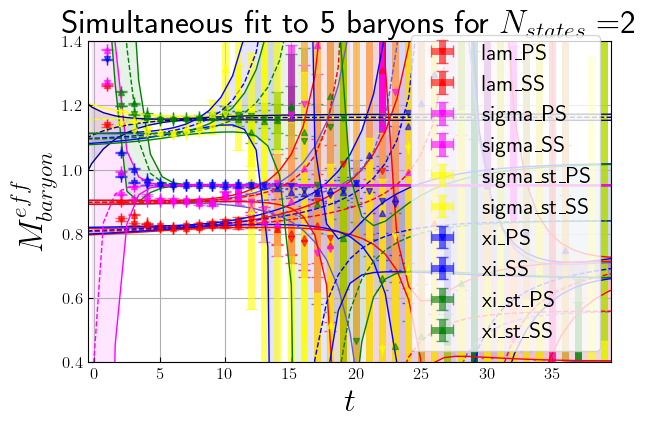

Abbreviation: a15m130
╒════╤═══════════════╤═══════════════╤════════════╤════════════╤══════════╤══════════╤══════════╤═════════════╤═════════════╤═════════╤════════════╤════════════╤════════════╤════════════╤═════════╤═════════╤══════════╤═══════════════╤════════╤═════════════╤═══════╤════════════╤══════════╤═══════════════╤═════════════╤══════════════════╕
│    │ 0             │ 1             │ 2          │ 3          │ 4        │ 5        │ 6        │ 7           │ 8           │ 9       │ 10         │ 11         │ 12         │ 13         │ 14      │ 15      │ 16       │ 17            │ 18     │ 19          │ 20    │ 21         │ 22       │ 23            │ 24          │ 25               │
╞════╪═══════════════╪═══════════════╪════════════╪════════════╪══════════╪══════════╪══════════╪═════════════╪═════════════╪═════════╪════════════╪════════════╪════════════╪════════════╪═════════╪═════════╪══════════╪═══════════════╪════════╪═════════════╪═══════╪════════════╪══════════╪═══════════

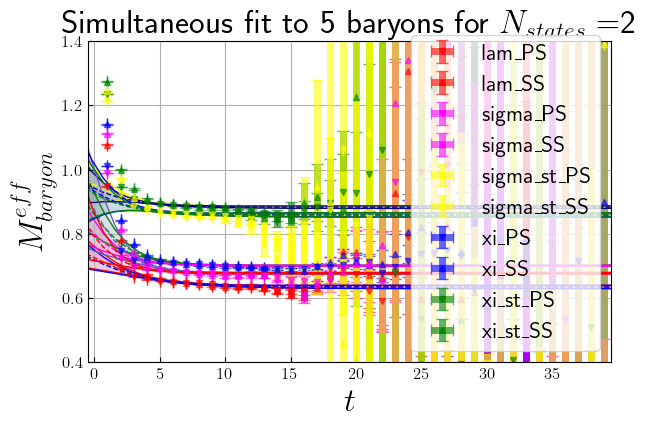

Abbreviation: a12m220_ms
╒════╤════════════╤════════════╤═══════════════╤═══════════════╤══════════╤══════════╤══════════╤═════════════╤═════════════╤═════════╤═════════╤════════════╤════════════╤═════════╤════════════╤════════════╤══════════╤═══════════════╤════════╤═════════════╤═══════╤════════════╤══════════╤═══════════════╤═════════════╤══════════════════╕
│    │ 0          │ 1          │ 2             │ 3             │ 4        │ 5        │ 6        │ 7           │ 8           │ 9       │ 10      │ 11         │ 12         │ 13      │ 14         │ 15         │ 16       │ 17            │ 18     │ 19          │ 20    │ 21         │ 22       │ 23            │ 24          │ 25               │
╞════╪════════════╪════════════╪═══════════════╪═══════════════╪══════════╪══════════╪══════════╪═════════════╪═════════════╪═════════╪═════════╪════════════╪════════════╪═════════╪════════════╪════════════╪══════════╪═══════════════╪════════╪═════════════╪═══════╪════════════╪══════════╪════════

In [ ]:
from tabulate import tabulate



abbreviations = [f[:-3] for f in os.listdir(input_dir) if f.endswith('.py')]

for abbr in abbreviations:
    fit_params = os.path.join(input_dir, f"{abbr}.py")
    if not os.path.exists(fit_params):
        print(f"Error: input file {fit_params} does not exist!")
        continue

    with open(fit_params, 'r') as f:
        input_file_contents = f.read()

    if 'p_dict' not in input_file_contents:
        print(f"Error: input file {fit_params} does not contain a dictionary called 'p_dict'!")
        continue

    try:
        p_dict = {}
        exec(input_file_contents, p_dict)
    except Exception as e:
        print(f"Error: Failed to execute the contents of input file {fit_params}!\n{str(e)}")
        continue

    if 'tag' not in p_dict:
        print(f"Warning: input file {fit_params} does not contain a dictionary called 'tag' within the 'p_dict' dictionary! Adding default values...")
        p_dict['tag'] = {
            'sigma' : 'sigma',
            'sigma_st' : 'sigma_st',
            'xi' :  'xi',
            'xi_st' : 'xi_st',
            'lam' : 'lam',
        }

    try:
        hyperon_fit = fa.analyze_hyperon_corrs(data_file, p_dict, model_type=model_type,
                                               bs=False, bs_file=bs_data_file,
                                               bs_path=abbr, bs_N=bs_N, bs_seed=bs_seed)
    except KeyError:
        print(f"KeyError: Error analyzing hyperons for input file {fit_params}. Skipping abbreviation {abbr}.")
        continue

    my_fit = hyperon_fit.get_fit()

    out_path = os.path.join(fit_results_dir, abbr, model_type)
    ld.pickle_out(fit_out=my_fit, out_path=out_path, species="hyperons")
    plot1 = hyperon_fit.return_best_fit_info()
    plot2 = hyperon_fit.plot_effective_mass(t_plot_min=t_plot_min, t_plot_max=t_plot_max, model_type=model_type,
                                            show_plot=True, show_fit=True)

    output_dir = os.path.join(fit_results_dir, abbr, f"{model_type}_{abbr}")
    os.makedirs(output_dir, exist_ok=True)
    output_pdf = os.path.join(output_dir, 'output.pdf')
    with PdfPages(output_pdf) as pp:
        pp.savefig(plot1)
        pp.savefig(plot2)

    params_df = pd.DataFrame(my_fit.p).transpose()

    print("Abbreviation:", abbr)
    print(tabulate(params_df, headers='keys', tablefmt='fancy_grid'))

    # Ask the user if the fit result is acceptable
    while True:
        result = input(f"Is the fit result for abbreviation {abbr} acceptable? (y/n): ")
        if result == "y":
            # Save the result and skip this fit in future runs
            out_path = 'fit_results/{0}/{1}/'.format(abbr, model_type)
            ld.pickle_out(fit_out=my_fit, out_path=out_path, species="hyperons")
            break
        elif result == "n":
            break


In [45]:
from importlib import reload
from tabulate import tabulate
importlib.reload(xfa)
importlib.reload(i_o)
importlib.reload(fit)
input_output = i_o.InputOutput()
importlib.reload(priors)
new_prior = priors.prior
data, ens = input_output.get_data(units='lam_chi')
print(data)
# new_prior = input_output.make_prior(data,prior)
phys_point_data = input_output.get_data_phys_point()

# initialize xpt models
with open('../xpt/models.yaml', 'r') as f:
    models = yaml.load(f, Loader=yaml.FullLoader)

def filter_prior_keys(prior, model_info, particles):
    # Extract relevant keys from the particles
    relevant_keys = set()
    for particle in particles:
        relevant_keys.add(f"m_{{{particle},0}}")

        if particle != "proton" and particle != "delta":
            relevant_keys.add(f"s_{{{particle}}}")
        else:
            relevant_keys.add(f"s_{{{particle},bar}}")

        for p in range(1, 5):
            relevant_keys.add(f"a_{{{particle},{p}}}")
            relevant_keys.add(f"b_{{{particle},{p}}}")

        for other_particle in particles:
            relevant_keys.add(f"g_{{{particle},{other_particle}}}")

    filtered_prior = {k: v for k, v in prior.items() if k in relevant_keys}
    return filtered_prior
def get_filtered_prior_keys(particles, order, prior):
    keys = []
    # for p in particles:
    for k in prior.keys():
            # if p in k:
        keys.append(k)
    return keys

def filter_relevant_prior_keys(model_info, prior):
    orders = ['llo', 'lo', 'nlo', 'n2lo']
    particles = model_info['particles']
    order_chiral = model_info['order_chiral']
    order_disc = model_info['order_disc']
    order_strange = model_info['order_strange']
    order_light = model_info['order_light']

    highest_order = max([order_chiral, order_disc, order_strange, order_light])

    relevant_prior_keys = []
    for order in orders:
        if orders.index(order) > orders.index(highest_order):
            break
        relevant_prior_keys.extend(get_filtered_prior_keys(particles, order, prior))

    # Filter priors based on the highest order and particles
    filtered_prior = {k: v for order in orders for k, v in prior[order].items()
                      if k in relevant_prior_keys}

    return filtered_prior

def recalibrate_prior(prior, data,fit_result, scale_factor):
    excluded = {
        'm_k', 'm_pi', 'lam_chi', 'eps2_a','m_xi','m_xi_st'
    }
    new_prior = prior.copy()
    for key in fit_result.p:
        if key not in excluded:
        # if key in fit_result.p:
            new_prior[key] = fit_result.p[key], scale_factor * fit_result.psdev[key]
        else:
            new_prior[key] = data[key]
    return new_prior


xi_models = models['models']['xi_system']

results = []
# for key, item in xi_models.items():
model_fit = fit.FitRoutine(
data=data, prior=new_prior, emp_bayes=False, empbayes_grouping=None,
model_info=xi_models['xi:xi_st:s_n2lo:d_n2lo:x_n2lo:l_n2lo:w0imp:fv:xpt'])
my_fit = model_fit.fit
print(my_fit)
if my_fit is None:
    print(f"Skipping model {key} due to fit error.")

    # Recalibrate priors based on the initial fit
    recalibrated_prior = recalibrate_prior(new_prior,data, my_fit, scale_factor=2)
    print(recalibrated_prior)

    # # Append results to list
    # try:
    #     result = {'Model': key, 'Chi2': my_fit_recalibrated.chi2, 'q': my_fit_recalibrated.Q}
    #     if 'm_{xi,0}' in my_fit_recalibrated.p:
    #         result['xi'] = my_fit_recalibrated.p['m_{xi,0}']
    #     if 'm_{xi_st,0}' in my_fit_recalibrated.p:
    #         result['xi_st'] = my_fit_recalibrated.p['m_{xi_st,0}']
    #     results.append(result)
    # except KeyError as e:
    #     print(f"KeyError encountered for model {key}: {e}")
    #     continue

# # create dataframe from results list and print it
# results_df = pd.DataFrame(results)
# print(tabulate(results_df, headers='keys', tablefmt='psql'))

# # plot results
# fig, ax = plt.subplots()
# ax.scatter(results_df['q'], results_df['Chi2'], marker='o')
# ax.set_xlabel('q')
# ax.set_ylabel('Chi2')
# ax.set_title('xi system')
# for i, txt in enumerate(results_df['Model']):
#     ax.annotate(txt, (results_df['q'][i], results_df['Chi2'][i]))
# plt.show()


['a06m310L', 'a09m135', 'a09m350', 'a09m400', 'a12m130', 'a12m220L', 'a12m220S', 'a12m310', 'a12m350', 'a12m400', 'a15m220', 'a15m310']
{'m_lambda': array([1255(11), 1260(10), 1303(10), 1090.9(8.0), 1123.2(8.2),
       1134.4(8.3), 1187.4(8.7), 1213.4(8.8), 1252.5(9.1), 1103.0(7.3),
       1162.1(7.7)], dtype=object), 'm_sigma': array([1311(12), 1312(11), 1346(11), 1186.1(8.7), 1208.5(8.8),
       1211.0(8.8), 1248.0(9.1), 1275.2(9.3), 1297.8(9.5), 1194.4(7.9),
       1236.8(8.2)], dtype=object), 'm_sigma_st': array([1501(13), 1571(13), 1600(13), 1461(11), 1480(11), 1481(11),
       1506(11), 1535(11), 1556(11), 1442.6(9.6), 1499(10)], dtype=object), 'm_xi_st': array([1642(15), 1625(13), 1671(13), 1535(11), 1555(11), 1558(11),
       1580(12), 1598(12), 1622(12), 1517(10), 1557(10)], dtype=object), 'm_xi': array([1410(13), 1388(11), 1411(11), 1271.4(9.3), 1282.4(9.4),
       1288.3(9.4), 1318.5(9.6), 1335.6(9.7), 1357.8(9.9), 1257.6(8.4),
       1294.3(8.6)], dtype=object), 'm_omega': 

## Xi, Xi* system SU(2) HBXPT extrapolation ##

In [46]:
# empirical bayes prior study 
importlib.reload(fit)
emp_fit = fit.FitRoutine(empbayes_grouping='disc',emp_bayes=True,
data=data, prior=new_prior, model_info=xi_models['xi:xi_st:s_n2lo:d_n2lo:x_n2lo:l_n2lo:w0imp:fv:xpt'])
print(data)
emp = emp_fit._make_empbayes_fit(observable='xi')

{'m_lambda': array([1255(11), 1260(10), 1303(10), 1090.9(8.0), 1123.2(8.2),
       1134.4(8.3), 1187.4(8.7), 1213.4(8.8), 1252.5(9.1), 1103.0(7.3),
       1162.1(7.7)], dtype=object), 'm_sigma': array([1311(12), 1312(11), 1346(11), 1186.1(8.7), 1208.5(8.8),
       1211.0(8.8), 1248.0(9.1), 1275.2(9.3), 1297.8(9.5), 1194.4(7.9),
       1236.8(8.2)], dtype=object), 'm_sigma_st': array([1501(13), 1571(13), 1600(13), 1461(11), 1480(11), 1481(11),
       1506(11), 1535(11), 1556(11), 1442.6(9.6), 1499(10)], dtype=object), 'm_xi_st': array([1642(15), 1625(13), 1671(13), 1535(11), 1555(11), 1558(11),
       1580(12), 1598(12), 1622(12), 1517(10), 1557(10)], dtype=object), 'm_xi': array([1410(13), 1388(11), 1411(11), 1271.4(9.3), 1282.4(9.4),
       1288.3(9.4), 1318.5(9.6), 1335.6(9.7), 1357.8(9.9), 1257.6(8.4),
       1294.3(8.6)], dtype=object), 'm_omega': array([1767(16), 1710(14), 1741(14), 1609(12), 1471(11), 1630(12),
       1655(12), 1664(12), 1671(12), 1581(11), 1615(11)], dtype=objec

TypeError: 'NoneType' object is not iterable

In [6]:

import xpt.plots as plots
importlib.reload(plots)
plots.plot_fit(ens=ens,fit_out=my_fit,xparam='xi',)

<module 'xpt.plots' from '/home/gmoney/lqcd/hyperon-xpt-master/xpt/plots.py'>

In [ ]:
['fit_div_lam = fit.fit_routine(prior=prior, data=data_div, model_info=model_info_div_lam)
fit_div_lam_out = fit_div_lam.fit
print(fit_div_lam_out)


SyntaxError: unterminated string literal (detected at line 1) (346027678.py, line 1)

In [ ]:
fit_sigma = fit.fit_routine(prior=prior, data=data,
                            model_info=model_info_sigma)
fit_sigma_out = fit_sigma.fit
print(fit_sigma_out.y)


{
    'proton':
    array([1121(10), 958.4(7.7), 984.4(7.9), 1110.7(8.9), 1158.1(9.3),
           1211.3(9.7), 934.1(6.8), 998.3(7.3), 1074.4(7.8), 1124.0(8.2),
           1168.4(8.5), 950.8(6.3), 993.1(6.6), 1078.1(7.2), 1057.1(7.0),
           1092.9(7.3), 1158.1(7.7)], dtype=object),
}


In [ ]:
fit_test = fit.fit_routine(prior=prior, data=data, model_info=model_info)
fit_out = fit_test.fit
print(fit_out.format(maxline=True))


Least Square Fit:
  chi2/dof [dof] = 1.3 [17]    Q = 0.17    logGBF = -85.26

Parameters:
     m_{proton,0}        902 (10)      [     900 (400) ]  
     b_{proton,2}     -6e-13 +- 5      [     0.0 (5.0) ]  
     b_{proton,4}     -4e-12 +- 5      [     0.0 (5.0) ]  
     b_{proton,6}       0.4 (5.0)      [     0.0 (5.0) ]  
     d_{proton,a}     -4e-13 +- 5      [     0.0 (5.0) ]  
    d_{proton,aa}      2e-12 +- 5      [     0.0 (5.0) ]  
    d_{proton,al}     -2e-12 +- 5      [     0.0 (5.0) ]  
   d_{proton,all}      -1.4 (4.9)      [     0.0 (5.0) ]  
   d_{proton,aal}       0.2 (1.0)      [     0.0 (5.0) ]  
     d_{proton,s}      -0.75 (74)      [     0.0 (5.0) ]  
    d_{proton,as}       8.7 (2.1)      [     0.0 (5.0) ]  *
    d_{proton,ls}      -2.5 (4.8)      [     0.0 (5.0) ]  
    d_{proton,ss}       2.8 (4.4)      [     0.0 (5.0) ]  
g_{proton,proton}     0.02 (4.99)      [     1.3 (5.0) ]  
 g_{proton,delta}      -1.13 (41)      [     0.9 (5.0) ]  
      m_{delta,0}      1

In [ ]:
from importlib import reload
reload(fa)
fit_analysis = fa.fit_analysis(
    phys_point_data=phys_point_data, data=data, model_info=model_info, prior=prior)
fit_analysis_sigma = fa.fit_analysis(
    phys_point_data=phys_point_data, data=data, model_info=model_info_sigma, prior=prior)
extrap_mass = fit_analysis.extrapolated_mass
extrap_mass_deriv = fit_analysis_sigma.extrapolated_mass
m_proton = extrap_mass['proton']
m_proton_deriv = extrap_mass_deriv['proton']


{'proton': 944.0(7.1)}


In [ ]:
reload(io)
m_pi = phys_point_data['m_pi']
lam_chi = phys_point_data['lam_chi']
e_pi = m_pi / lam_chi
sigma = m_pi**2 * gv.deriv(m_proton, m_pi**2)
l3 = gv.gvar('3.53(26)')
l4 = gv.gvar('4.73(10)')
sigma_analytic = e_pi/2 * (1 + e_pi**2*(5/2 - l3/2 - 2*l4)) * m_proton_deriv
print('sigma w/ gv.deriv:', sigma)
print('sigma analytic:', sigma_analytic)


sigma w/ gv.deriv: 53.12(24)
sigma analytic: 48.53(38)


In [ ]:
print(fit_analysis.error_budget)


KeyError: 'm_{proton,0}'